<a href="https://colab.research.google.com/github/hsgw/keyboard-made-by-python/blob/main/notebook/jp/pcb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 基板の設計
このノートブックではキーボードの基板を設計し、最終的に基板を生産するためのデータ`ガーバーファイル`を得ることを目標とします。

通常の工程で基板を作るにはまず`回路図エディタ`で`回路図`を書いて使用する部品とその結線情報をまとめて`ネットリスト`として出力し、`基板エディタ`を用いて実際に`基板`へ部品を配置・配線します。

## 記事を読むための注意
このノートブックには2回実行すると正常に動作しないセルが含まれています。

それを防止するために上のメニューから`ランタイム>全てのセルを実行`してから読み始めると良いかもしれません。実行完了には少し時間がかかります。

## リソースのダウンロード
以下のセルを実行してkicadのライブラリや他のリソースが入ったリポジトリをクローンしておきます。

In [3]:
!git clone https://github.com/hsgw/keyboard-made-by-python/

Cloning into 'keyboard-made-by-python'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 102 (delta 30), reused 63 (delta 10), pack-reused 0
Receiving objects: 100% (102/102), 551.65 KiB | 14.14 MiB/s, done.
Resolving deltas: 100% (30/30), done.


# skidlでネットリスト(回路図)を設計する
Pythonを使った設計では回路図を書かずにコードで使用する部品と結線情報を定義してネットリストを出力します。

[skidl](https://github.com/devbisme/skidl)というライブラリを用います。このライブラリは独自フォーマットの部品ライブラリだけでなく、kicadの部品ライブラリをインポートして使用します。また、ネットリストはkicadのPCBエディタと互換性があり直接kicadへ読み込んで回路図を書くこともできます。

- skidl  https://github.com/devbisme/skidl
- skidlのドキュメント  https://devbisme.github.io/skidl/

## skidlのインストールとインポート
[skidl](https://github.com/devbisme/skidl)をインストールしてインポートします。

In [4]:
# インストールには時間がかかります
!pip install skidl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.7 MB 1.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 191 kB 84.2 MB/s 
     |████████████████████████████████| 240 kB 61.5 MB/s 
     |████████████████████████████████| 313 kB 64.9 MB/s 
  Created wheel for skidl: filename=skidl-1.1.0-py2.py3-none-any.whl size=677674 sha256=f763a0e403af1401ae15934813f06ecbaf2fa442e4eaae387e92c72f21b33743
  Stored in directory: /root/.cache/pip/wheels/24/68/c6/fcbdece7240732eadff168707b7bc70c872a880387d0e1f90f
  Created wheel for kinparse: filename=kinparse-1.2.0-py2.py3-none-any.whl size=7860 sha256=51f413cf32371e53ee337e68e062cd9173bc2c31d88f891dfa7d29d4d017b1e5
  Stored in directory: /root/.cache/pip/wheels/52/6e/bb/abe9c7e706ba77a6905f320ba494d649802cc02dc78ecea932
  Created wheel for

In [5]:
# kicadのデフォルトパスが環境変数に設定されていないのでWarningが出ます
from skidl import *

## 定数を宣言する
何度も出てくる値を定数として宣言しておきます。この値を使い回すことで変更に強い設計になります。


In [6]:
KEY_COUNT = 10
COL_COUNT = 4
ROW_COUNT = 3
MATRIX_MAP = [
        (0,1),(0,2),(0,3),  
        (1,1),(1,2),(1,3),
  (2,0),(2,1),(2,2),(2,3)
]

## kicadライブラリの読み込みと部品の準備
使用するkicadライブラリのパスを追加をします。

kicadがインストールされている環境であれば通常のライブラリへのパスがデフォルトで追加されているはずですが、今回はkicadのインストールされていない環境で実行するために使う部品だけ別に用意しておきます。
先程githubからcloneしてきた`keyboard-made-by-python/hardware/kicad_libs`に入っています。

シンボルとフットプリントを結びつけて必要な個数だけ部品を用意します。

In [7]:
# 使用するライブラリを登録する
# シンボル・フットプリントどちらも別で登録する
lib_search_paths[KICAD].append("keyboard-made-by-python/hardware/kicad_libs")
footprint_search_paths[KICAD].append("keyboard-made-by-python/hardware/kicad_libs/kicad.pretty")

# 同じ部品を何回も使うならシンボルとフットプリントを結びつけたテンプレートとして読み込んでおく
diode = Part(
  "kicad_symbols", "D_Small_ALT", TEMPLATE, footprint="kicad:D_SOD123_hand"
)
switch = Part(
  "kicad_symbols",
  "SW_Push",
  TEMPLATE,
  footprint="kicad:SW_Cherry_MX_1.00u_PCB",
)

# 宣言した定数とテンプレートを使ってダイオードとスイッチを用意する
# それぞれ KEY_COUNT 個用意して配列にいれておく
diodes = diode(KEY_COUNT)
switches = switch(KEY_COUNT)

# ひとつしか使わない部品はそのまま読み込む
xiao = Part("kicad_symbols", "xiao_rp2040", footprint="kicad:xiao_rp2040")
oled = Part("kicad_symbols", "oled_i2c", footprint="kicad:oled_i2c")

# printするとシンボルのPin情報が見えます
print(diode, switch, xiao, oled)


 D_Small_ALT (): Diode, small symbol, filled shape
    Pin None/1/K/PASSIVE
    Pin None/2/A/PASSIVE 
 SW_Push (): Push button switch, generic, two pins
    Pin None/1/1/PASSIVE
    Pin None/2/2/PASSIVE 
 xiao_rp2040 (): 
    Pin U1/1/P26/ADC0/I2C1_SDA/BIDIRECTIONAL
    Pin U1/10/UART1_TX/I2C0_SDA/SPI0_RX/P4/BIDIRECTIONAL
    Pin U1/11/I2C1_SCL/SPI0_TX/P3/BIDIRECTIONAL
    Pin U1/12/3.3V/POWER-OUT
    Pin U1/13/GND/POWER-OUT
    Pin U1/14/5V/POWER-OUT
    Pin U1/2/P27/ADC1/I2C1_SCL/BIDIRECTIONAL
    Pin U1/3/P28/ADC2/BIDIRECTIONAL
    Pin U1/4/P29/ADC3/BIDIRECTIONAL
    Pin U1/5/P6/I2C1_SDA/SPI0_SCK/BIDIRECTIONAL
    Pin U1/6/P7/I2C1_SCL/SPI0_TX/BIDIRECTIONAL
    Pin U1/7/P0/UART0_TX/I2C0_SDA/SPI0_RX/BIDIRECTIONAL
    Pin U1/8/UART0_RX/I2C0_SCL/SPI0_CSn/P1/BIDIRECTIONAL
    Pin U1/9/I2C1_SDA/SPI0_SCK/P2/BIDIRECTIONAL 
 oled_i2c (): 
    Pin DISP1/1/SDA/BIDIRECTIONAL
    Pin DISP1/2/SCL/INPUT
    Pin DISP1/3/Vcc/POWER-IN
    Pin DISP1/4/GND/POWER-IN


## PinやNetを接続する
用意した部品のピン同士を接続を入力して回路の構成を定義します。

このときなるべく配線自体に`Net`名をつけるようにします。`Net`を基準に部品の`Pin`を繋いでいくことで同じところにつながるもの(電源やスイッチマトリクス)を整理して見やすいコードにします。また、kicadへネットリストをインポートしたときに表示されるので目印にもなります。

今回の設計でも基板配線時に`ピン番号`を`Net`から読み出します。

In [8]:
# Pin情報を表示しながら配線すると便利
print(xiao)


 xiao_rp2040 (): 
    Pin U1/1/P26/ADC0/I2C1_SDA/BIDIRECTIONAL
    Pin U1/10/UART1_TX/I2C0_SDA/SPI0_RX/P4/BIDIRECTIONAL
    Pin U1/11/I2C1_SCL/SPI0_TX/P3/BIDIRECTIONAL
    Pin U1/12/3.3V/POWER-OUT
    Pin U1/13/GND/POWER-OUT
    Pin U1/14/5V/POWER-OUT
    Pin U1/2/P27/ADC1/I2C1_SCL/BIDIRECTIONAL
    Pin U1/3/P28/ADC2/BIDIRECTIONAL
    Pin U1/4/P29/ADC3/BIDIRECTIONAL
    Pin U1/5/P6/I2C1_SDA/SPI0_SCK/BIDIRECTIONAL
    Pin U1/6/P7/I2C1_SCL/SPI0_TX/BIDIRECTIONAL
    Pin U1/7/P0/UART0_TX/I2C0_SDA/SPI0_RX/BIDIRECTIONAL
    Pin U1/8/UART0_RX/I2C0_SCL/SPI0_CSn/P1/BIDIRECTIONAL
    Pin U1/9/I2C1_SDA/SPI0_SCK/P2/BIDIRECTIONAL


In [9]:
# スイッチマトリクスのROW,COLのネットリストが入った配列を作る
netRows = [Net(f"ROW{i}") for i in range(ROW_COUNT)]
netCols = [Net(f"COL{i}") for i in range(COL_COUNT)]


# ROWのNet -> スイッチの1ピン  スイッチの2ピン -> ダイオードのカソード  ダイオードのアノード -> COLのNet をまとめて宣言する
# NetやPinは`&`で繋ぐと接続される
# 部品のPinには part["pin name"]でアクセス出来る
# 部品のPinの添字を2つにするとinとoutになる
# 例: sw["1"]につながるNetかPin & sw["1 2"] & sw["2"]に繋がるNetかPin
for sw, d, mapping in zip(switches, diodes, MATRIX_MAP):
  netRows[mapping[0]] & sw["1 2"] & d["K A"] & netCols[mapping[1]]

# スイッチマトリクスとxiaoを接続する
# NetにPinを`+`ことで接続する
netCols[0] += xiao[8]
netCols[1] += xiao[3]
netCols[2] += xiao[4]
netCols[3] += xiao[5]

netRows[0] += xiao[1]
netRows[1] += xiao[6]
netRows[2] += xiao[7]

# oledとxiaoも接続する
# Net("3.3V")みたいに直接Netを宣言して繋いでもOK
Net("3.3V") & oled["Vcc"] & xiao["3.3V"]
Net("GND") & oled["GND"] & xiao["GND"]
Net("SDA") & oled["SDA"] & xiao[9]
Net("SCL") & oled["SCL"] & xiao[11]

# printすると接続されているPinが表示される
print(netRows[0])

ROW0: Pin SW1/1/1/PASSIVE, Pin SW2/1/1/PASSIVE, Pin SW3/1/1/PASSIVE, Pin U1/1/P26/ADC0/I2C1_SDA/BIDIRECTIONAL


## ERCとネットリストの出力
ERC(Electrical Rule Check・回路図のルールチェック)をかけて、ネットリストを出力します。
これで回路図・ネットリストは完成です！

In [10]:
# 他のセルを複数回実行しているとエラーが出たり回路が複数個になったりするかもしれません
# そのときは`メニュー`の`ランタイム -> ランタイムを再起動`して最初からやりなおすか`再起動してすべてのセルを実行`してください
# 未結線のWarningが出ますが問題ありません
ERC()
generate_netlist(file_="keyboard.net")

ERC WARNING: Unconnected pin: BIDIRECTIONAL pin 10/UART1_TX/I2C0_SDA/SPI0_RX/P4 of xiao_rp2040/U1.
ERC WARNING: Unconnected pin: POWER-OUT pin 14/5V of xiao_rp2040/U1.
ERC WARNING: Unconnected pin: BIDIRECTIONAL pin 2/P27/ADC1/I2C1_SCL of xiao_rp2040/U1.

3 warnings found while running ERC.
0 errors found while running ERC.


No errors or warnings found while generating netlist.



'(export (version D)\n  (design\n    (source "/content/skidl")\n    (date "12/18/2022 07:57 AM")\n    (tool "SKiDL (1.1.0)"))\n  (components\n    (comp (ref D1)\n      (value D_Small_ALT)\n      (footprint kicad:D_SOD123_hand)\n      (fields\n        (field (name F0) D)\n        (field (name F1) D_Small_ALT)\n        (field (name F2) kicad:D_SOD123_hand))\n      (libsource (lib kicad_symbols) (part D_Small_ALT))\n      (sheetpath (names /top/9448862795237660437) (tstamps /top/9448862795237660437)))\n    (comp (ref D10)\n      (value D_Small_ALT)\n      (footprint kicad:D_SOD123_hand)\n      (fields\n        (field (name F0) D)\n        (field (name F1) D_Small_ALT)\n        (field (name F2) kicad:D_SOD123_hand))\n      (libsource (lib kicad_symbols) (part D_Small_ALT))\n      (sheetpath (names /top/5946283477711124455) (tstamps /top/5946283477711124455)))\n    (comp (ref D2)\n      (value D_Small_ALT)\n      (footprint kicad:D_SOD123_hand)\n      (fields\n        (field (name F0) D)\n 

出力されたネットリストは今記事では使用しませんが、kicadのpcbnewのネットリスト読み込みからインポートしてそのまま基板を作ることも出来ます。

![pcbnewへネットリストをインポートした](https://github.com/hsgw/keyboard-made-by-python/blob/main/notebook/imgs/kicad_pcbnew.png?raw=1)

# pcbflowで基板を設計する
[pcbflow](https://github.com/michaelgale/pcbflow)を使って、skidlで設計したフットプリントとピンの接続情報を読み込み、基板上に実際に部品を配置し配線を繋いでいきます。随時、画像ファイルでプレビューをしたり、最終的には製造に必要なガーバーファイル一式を出力します。

配線は昔ながらの[Turtle graphics](https://docs.python.org/ja/3/library/turtle.html)風の表記で行います。

pcbflowは開発中(?)のようで意図しない動作や不具合があったため修正と追加をしました。今記事ではその[folk](https://github.com/hsgw/pcbflow/tree/fix_kicad)を使用します。

- pcbflow https://github.com/michaelgale/pcbflow
- pcvflowのドキュメントはREADME.mdにあります
- folkして修正したpcbflow https://github.com/hsgw/pcbflow/tree/fix_kicad

## pcbflowのダウンロードとインストール
以下のセルを実行してインストールします。
インポートしてエラーがないことを確認します。

In [11]:
# インストールに時間がかかります
!pip install git+https://github.com/hsgw/pcbflow/@fix_kicad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hsgw/pcbflow/ (to revision fix_kicad) to /tmp/pip-req-build-rts3h8is
  Running command git clone -q https://github.com/hsgw/pcbflow/ /tmp/pip-req-build-rts3h8is
  Running command git checkout -b fix_kicad --track origin/fix_kicad
  Switched to a new branch 'fix_kicad'
  Branch 'fix_kicad' set up to track remote branch 'fix_kicad' from 'origin'.
     |████████████████████████████████| 2.1 MB 34.3 MB/s 
     |████████████████████████████████| 67 kB 3.3 MB/s 
     |████████████████████████████████| 45 kB 4.2 MB/s 
     |████████████████████████████████| 69 kB 8.5 MB/s 
  Created wheel for pcbflow: filename=pcbflow-0.1.0-py3-none-any.whl size=133092 sha256=ca9df6ded1516eca8cd984a6690344532a825fdbfb8f06bb352c597878cffd49
  Stored in directory: /tmp/pip-ephem-wheel-cache-xd7j43zm/wheels/41/5b/88/bbc4d8b01ff25946caee371e43cf051d5e2f55188d85afe807
  Created wheel for 

In [12]:
from pcbflow import *

## 定数を宣言する
ネットリストと同じようによく使う値を定数として宣言しておきます。   
座標のY軸が反転していて違和感があったので変換するための関数も宣言しています。

In [13]:
BOARD_WIDTH = 76.0
BOARD_HEIGHT = 57.0

KEY_PITCH = 19.0

SCREW_HOLE = 2.2

LAYER_TOP = "GTL"
LAYER_BOTTOM = "GBL"

# Y軸の座標を反転させる関数
def pos(x, y):
  return (x, BOARD_HEIGHT - y)

## 基板と回路の変数を宣言する
基板と回路にアクセスするための変数を宣言しておきます。
基板はpcbflowのもの、回路はskidlのものです。

`board`の宣言時に外形の大きさを指定し、外形線を追加します。

In [14]:
# skidlで作った回路情報
circuit = builtins.default_circuit
# pcbflowの基板
board = Board((BOARD_WIDTH, BOARD_HEIGHT))
board.add_outline()

## デザインルールを設定する
ドリルの大きさや配線の太さなど、基板のデザインルールを設定します。

この設定を基本として基板を配線していきます。

In [15]:
board.drc.trace_width = 0.5        # 配線の太さ
board.drc.via_drill = 0.6          # ビアのドリル径
board.drc.via_annular_ring = 0.4   # ビアのパッド径
board.drc.clearance = 0.4          # 配線のクリアランス

## 固定用の穴をあける
スイッチの間に基板を固定するための穴を作ります。

In [16]:
board.add_hole(pos(KEY_PITCH * 2, KEY_PITCH), SCREW_HOLE)
board.add_hole(pos(KEY_PITCH * 3, KEY_PITCH), SCREW_HOLE)
board.add_hole(pos(KEY_PITCH * 3, KEY_PITCH * 2), SCREW_HOLE)
board.add_hole(pos(KEY_PITCH, KEY_PITCH * 2), SCREW_HOLE)

### 画像ファイルを出力してプレビューしてみる
ここで一度画像ファイルを出力して基板上に正しく穴があいているか確認してみます。

Rendering preview_top.['png']...
Rendering preview_top_docu.['png']...
Rendering preview_bot.['png']...
Rendering preview_bot_docu.['png']...


/usr/local/lib/python3.8/dist-packages/pcbflow/svgout.py:134: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  [renderpoly(po) for po in gto]
/usr/local/lib/python3.8/dist-packages/pcbflow/svgout.py:142: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for po in gto:


Rendering preview_all.['png']...


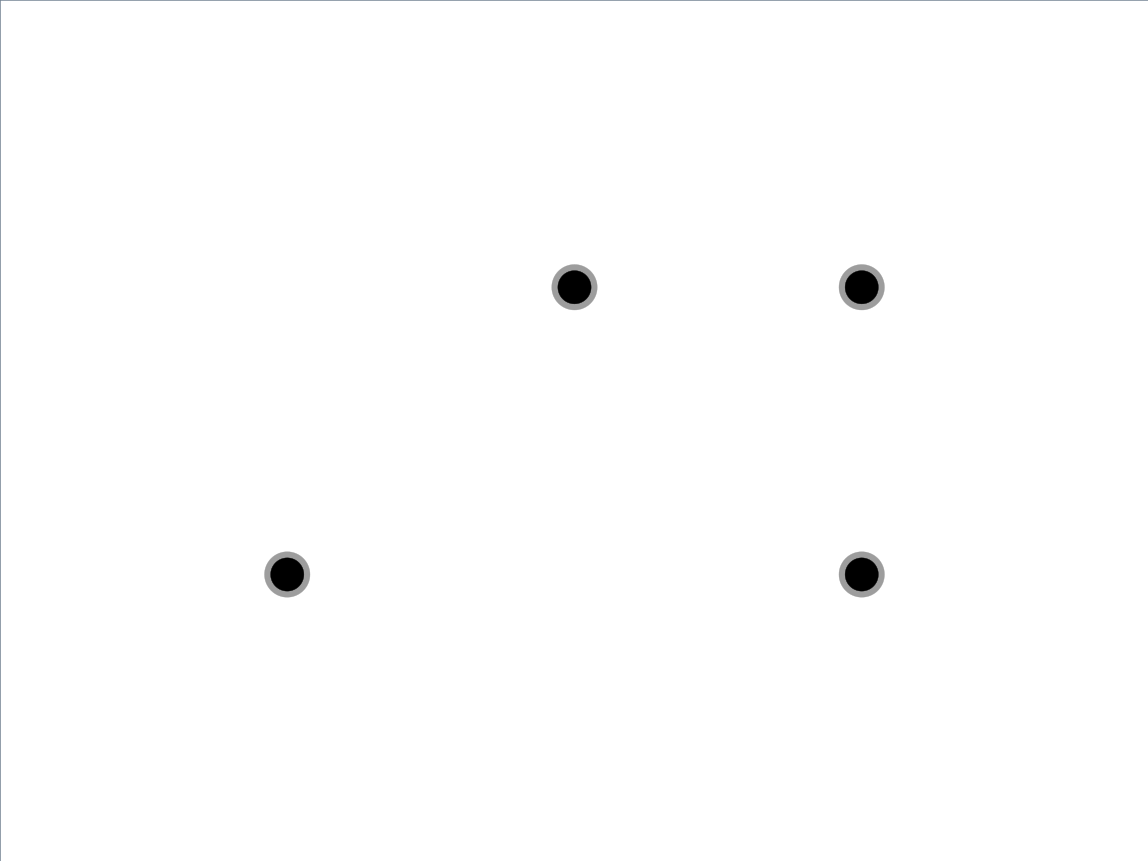

In [17]:
from IPython.display import Image

# 現在のboardをpngファイルとして書き出す
board.save_png("kbd_python", subdir="pcb_png")

# 表示
Image("pcb_png/kbd_python_preview_all.png")
# Image("pcb_png/kbd_python_preview_top.png")
# Image("pcb_png/kbd_python_preview_bot.png")

## 部品に位置情報を追加する
skidlの部品それぞれに基板上の位置・回転・実装面の情報を追加していきます。

今記事ではいきなり位置を指定していますが、基板に配置してはプレビューを繰り返しながら決めていきました。

In [18]:
# sw, d, xiao, oledはskidlのところで宣言した変数です

# スイッチとダイオードはブロックにまとめて位置を指定する
# ブロックごとにスイッチとダイオードの位置関係は同じ
for sw, d, mapping in zip(switches, diodes, MATRIX_MAP):
  sw.pos = pos(
    mapping[1] * KEY_PITCH + KEY_PITCH / 2,
    mapping[0] * KEY_PITCH + KEY_PITCH / 2,
  )
  sw.side = "top"
  sw.rotate = 0
  d.pos = (sw.pos[0] + 6, sw.pos[1] + 5)
  d.side = "bottom"
  d.rotate = 0

xiao.pos = pos(11.25, 11.5)
xiao.side = "bottom"
xiao.rotate = 0

oled.pos = pos(9.5, 36)
oled.side = "top"
oled.rotate = 270

## 基板に部品を配置する
追加した位置情報を元にskidlの部品をpcbflowの基板へ変換しながら配置していきます。

In [19]:
for part in circuit.parts:
  try:
    # skidlの部品を読み込んでpcbflowのboardに配置していく
    SkiPart(board.DC(part.pos).right(part.rotate), part, side=part.side)
  except AttributeError:
    print(f"{part.ref} has no pos or side")
    continue

### プレビュー

Rendering preview_top.['png']...
Rendering preview_top_docu.['png']...
Rendering preview_bot.['png']...


/usr/local/lib/python3.8/dist-packages/pcbflow/svgout.py:115: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  [renderpoly(p) for p in po]


Rendering preview_bot_docu.['png']...
Rendering preview_all.['png']...


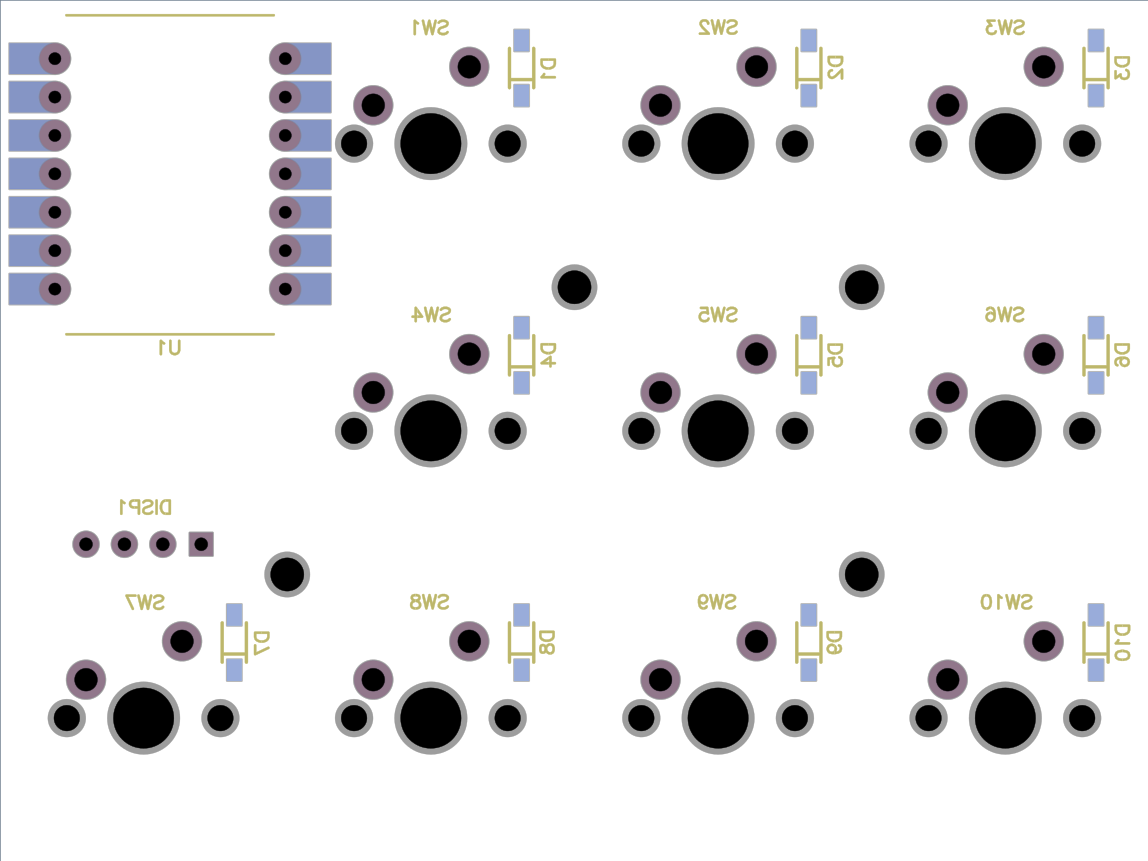

In [20]:
from IPython.display import Image

# 現在のboardをpngファイルとして書き出す
board.save_png("kbd_python", subdir="pcb_png")

# 表示
Image("pcb_png/kbd_python_preview_all.png")
# Image("pcb_png/kbd_python_preview_top.png")
# Image("pcb_png/kbd_python_preview_bot.png")

## 配線：xiao-スイッチ(ROW)
xiaoからスイッチのROWへの配線をします。   
Turtle記法を使ってxiaoから配線を引き出してスイッチの`Pad`に接続します。

skidlの`Pin`とpcbflowの`pads`は同じもの、部品のピンを指しています。

In [21]:
xiaoRef = "U1"

# skidlのNetから名前で検索してPadの番号を返す関数
# skidlのPin番号は1から、pcbflowのPad番号は0から始まる
def get_pin_number_from_net(netLabel, ref):
    net = Net.get(netLabel)
    return list((int(x.num) - 1 for x in net.pins if x.ref == ref))[0]

# skidlのNetから名前で検索して接続されているxiaoのPadを返す関数
# kicadライブラリの都合でPad番号がずれているのを修正して返す
# 最後のnewpath()は初期値に変な値が入っているのを初期化している
def xiao_pads(net: str):
  return (
    board.get_part(xiaoRef)
    .pads[get_pin_number_from_net(net, xiaoRef) + 14]
    .newpath()
  )

# Net:ROWに繋がったxiaoとスイッチのピンを繋ぐ
# ROWに繋がったxiaoのPad→レイヤーを指定→Turtle記法で配線→SWのパッドまで軸を合わせて配線
xiao_pads("ROW0").set_layer(LAYER_TOP).w("r 45").align_meet(
  board.get_part("SW1").pads[0], "x"
)
xiao_pads("ROW1").set_layer(LAYER_TOP).w("r 45").align_meet(
  board.get_part("SW4").pads[0], "y"
)
xiao_pads("ROW2").set_layer(LAYER_TOP).w("l 180 f 12 r 45").align_meet(
  board.get_part("SW8").pads[0], "y"
)

<at (24.690, 20.060) facing 135.000>

### プレビュー

Rendering preview_top.['png']...
Rendering preview_top_docu.['png']...
Rendering preview_bot.['png']...
Rendering preview_bot_docu.['png']...
Rendering preview_all.['png']...


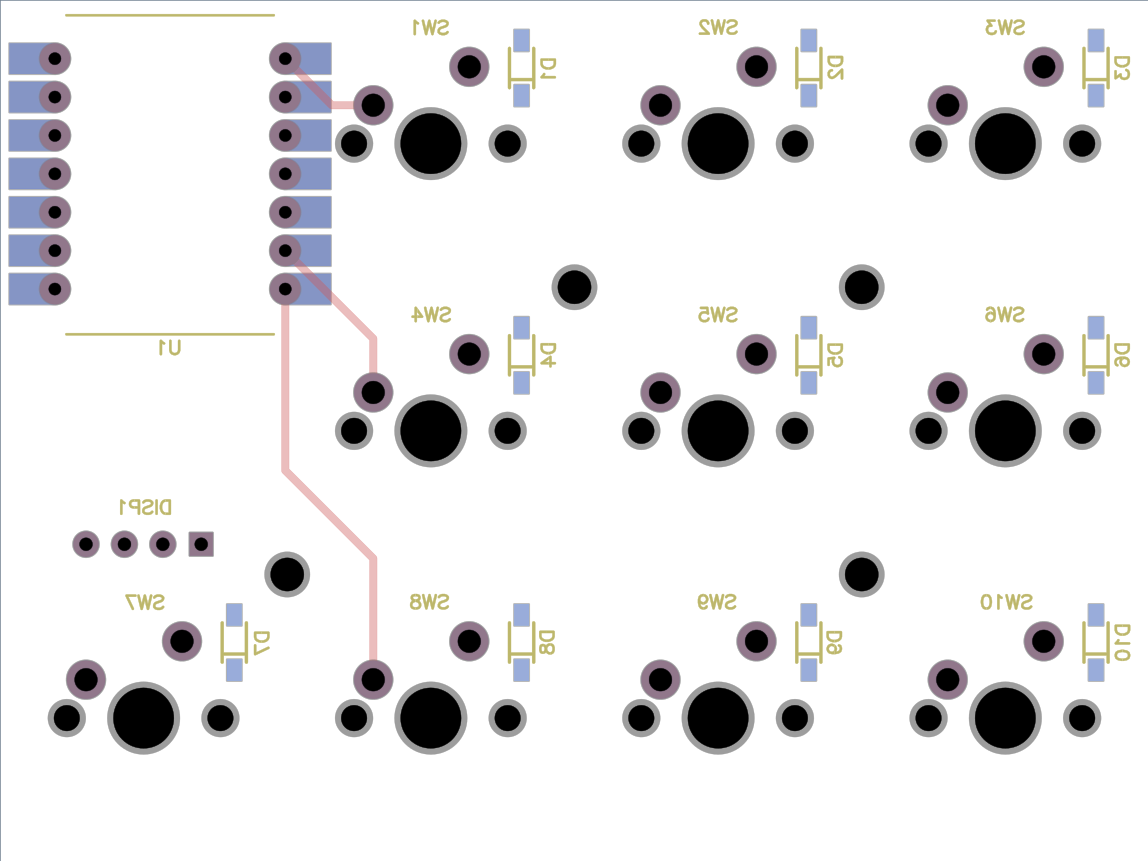

In [22]:
from IPython.display import Image

# 現在のboardをpngファイルとして書き出す
board.save_png("kbd_python", subdir="pcb_png")

# 表示
Image("pcb_png/kbd_python_preview_all.png")
# Image("pcb_png/kbd_python_preview_top.png")
# Image("pcb_png/kbd_python_preview_bot.png")

## 配線：ダイオード-スイッチ・スイッチ-スイッチ(ROW)・ダイオード-ダイオード(COL)
接続されているピンの位置関係が同じものであれば同じように接続できるので、ループを回して配線します。

COLの配線では途中でビアを作ります。ビアの情報を保存しておいて後ほどxiaoと接続します。

In [23]:
# スイッチとダイオードはブロックとして同じように並べたので同じように配線できる
# REF Noでアクセスしたいので1始まり
for i in range(1, KEY_COUNT + 1):
  sw = board.get_part(f"SW{i}")
  d = board.get_part(f"D{i}")
  # 配線をはじめるpadを指定→レイヤーを指定→Turtle記法で配線→パッドと軸を合わせて接続
  d.pads[0].set_layer(LAYER_BOTTOM).w("f 1 r 45").align_meet(sw.pads[1], "x")

# スイッチマトリクスのROWに繋がっているスイッチのPinは直線で並んでいるので同じように配線できる
# ROWによってスイッチの個数が違うので注意
for i in range(3):
  # ROWのNet情報からSWに繋がっているもののRef Noを配列にする
  refs = list(x.ref for x in netRows[i].pins if x.ref.startswith("SW"))
  for j in range(len(refs) - 1):
    # 配線を始めるpadを指定→新しいパスを作る→レイヤーの指定→Turtle記法で配線→指定したpadへ直線で接続
    board.get_part(refs[j]).pads[0].newpath().set_layer(LAYER_TOP).w(
      "r 90 f 2 l 45 f 1 r 45 f 2.5 r 45 f1"
    ).meet(board.get_part(refs[j + 1]).pads[0])

# ビアの情報を保存しておく配列
# xiaoと接続するときに使う
viaCol = [0] * 4

# スイッチマトリクスのCOL1-3に繋がるダイオードは直線に並んでいるので同じように配線できる
# 途中でビアを挟む
for i in range(1, 4):
  d1 = board.get_part(f"D{i}")
  d2 = board.get_part(f"D{i+3}")
  d3 = board.get_part(f"D{i+7}")
  # ビアの情報を保持しておくためにダイオード-ビアを先に配線する
  via = (
    d1.pads[1]
    .set_layer(LAYER_BOTTOM)
    .w("l 180 f 1.25 r 45 f 2 l 45 f 6.5 l 45")
    .align(d2.pads[1], "y")
    .wire()
    .via()
  )
  viaCol[i] = via
  # ビアから次のダイオードのPadまで配線する
  via.set_layer(LAYER_BOTTOM).meet(d2.pads[1])
  d2.pads[1].set_layer(LAYER_BOTTOM).w(
    "l 180 f 1 r 45 f 2 l 45 f 6.5 l 45"
  ).align_meet(d3.pads[1], "y")

### プレビュー

Rendering preview_top.['png']...
Rendering preview_top_docu.['png']...
Rendering preview_bot.['png']...
Rendering preview_bot_docu.['png']...
Rendering preview_all.['png']...


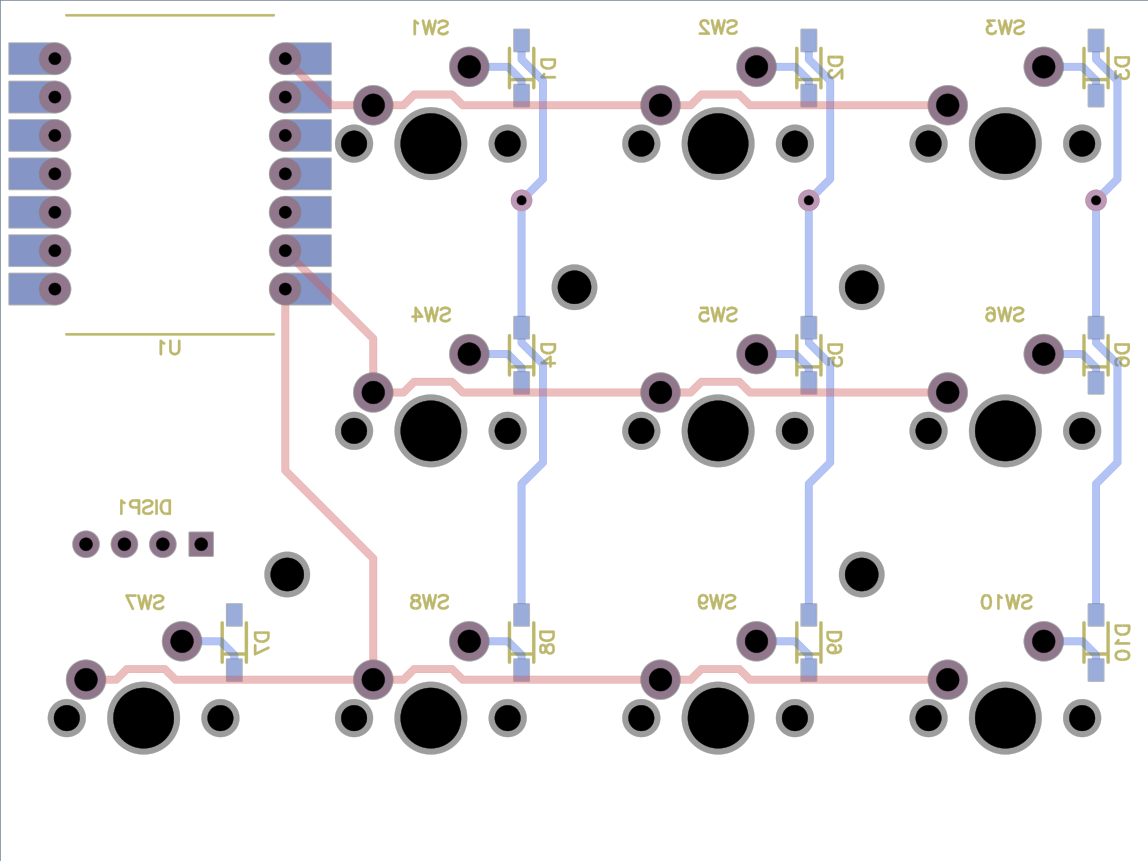

In [24]:
from IPython.display import Image

# 現在のboardをpngファイルとして書き出す
board.save_png("kbd_python", subdir="pcb_png")

# 表示
Image("pcb_png/kbd_python_preview_all.png")
# Image("pcb_png/kbd_python_preview_top.png")
# Image("pcb_png/kbd_python_preview_bot.png")

## 配線：ビア-xiao(COL)
保存しておいたビアからxiaoへ配線します。

In [25]:
# ビアからxiaoのpadへ配線する
viaCol[1].set_layer(LAYER_TOP).w("l 45 f 11 l 45").align_meet(
  xiao_pads("COL1"), "x"
)
viaCol[2].set_layer(LAYER_TOP).w("f 2 l 45 f 29.5 l 45").align_meet(
  xiao_pads("COL2"), "x"
)
viaCol[3].set_layer(LAYER_TOP).w("f 4 l 45 f 48.5 l 45").align_meet(
  xiao_pads("COL3"), "x"
)

<at (19.130, 42.960) facing 315.000>

### プレビュー

Rendering preview_top.['png']...
Rendering preview_top_docu.['png']...
Rendering preview_bot.['png']...
Rendering preview_bot_docu.['png']...
Rendering preview_all.['png']...


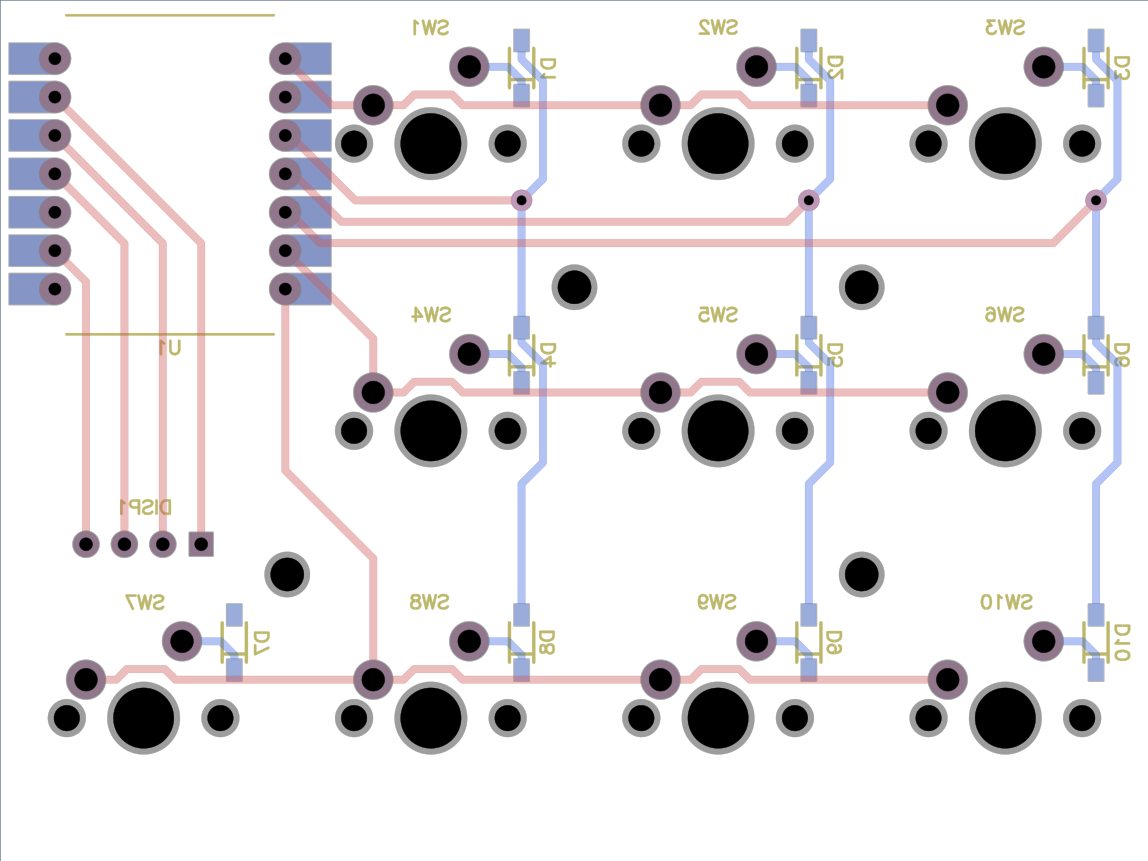

In [27]:
from IPython.display import Image

# 現在のboardをpngファイルとして書き出す
board.save_png("kbd_python", subdir="pcb_png")

# 表示
Image("pcb_png/kbd_python_preview_all.png")
# Image("pcb_png/kbd_python_preview_top.png")
# Image("pcb_png/kbd_python_preview_bot.png")

## 配線：xiao-OLED
xiaoからOLEDへ配線します。

Netの名前を列挙しておいてskidlのNet情報から接続するPadの番号を調べます。

In [26]:
oledRef = "DISP1"

# ビアからxiaoのpadへ配線する
for net in ["GND", "3.3V", "SCL", "SDA"]:
  oledPin = board.get_part(oledRef).pads[get_pin_number_from_net(net, oledRef)]
  xiao_pads(net).set_layer(LAYER_TOP).left(135).align_meet(oledPin, "y")

## 配線の完成
これで全ての配線が終わりました！

Rendering preview_top.['png']...
Rendering preview_top_docu.['png']...
Rendering preview_bot.['png']...
Rendering preview_bot_docu.['png']...
Rendering preview_all.['png']...


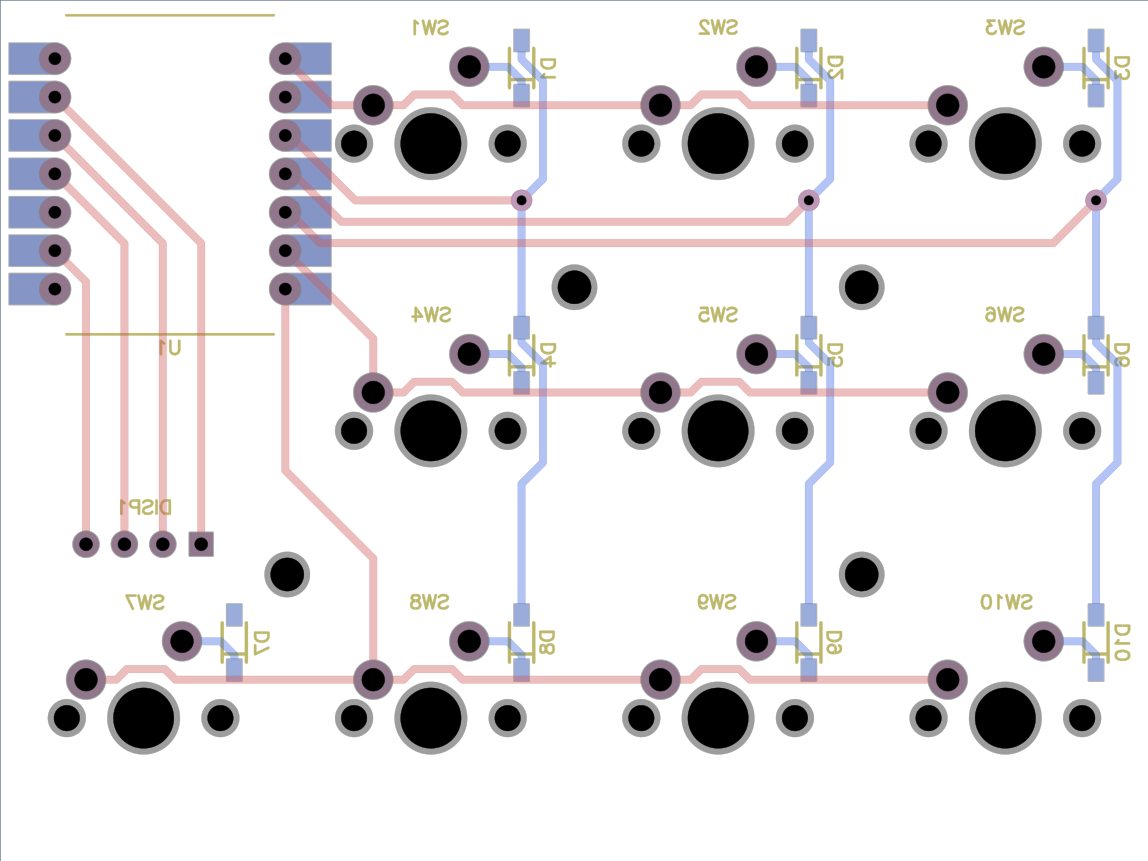

In [28]:
from IPython.display import Image

# 現在のboardをpngファイルとして書き出す
board.save_png("kbd_python", subdir="pcb_png")

# 表示
Image("pcb_png/kbd_python_preview_all.png")
# Image("pcb_png/kbd_python_preview_top.png")
# Image("pcb_png/kbd_python_preview_bot.png")

## 基板上に絵を配置する
基板のシルクレイヤーにロゴなどの画像を配置します。
使用する画像データは冒頭のリソース内にあります。

In [29]:
DIR_IMGS = "keyboard-made-by-python/"

board.add_bitmap(
  (47.5, 28.5), 
  DIR_IMGS + "hardware/imgs/python-logo.png",
  side="top",
  scale=0.85
)

board.add_bitmap(
  (11.25, 45),
  DIR_IMGS + "hardware/imgs/QR.png",
  side="bottom",
  scale=0.75,
)

board.add_bitmap(
  (11, 28.5),
  DIR_IMGS + "hardware/imgs/logo-python-powered-w-logo.png",
  side="bottom",
  layer="GBS",
  scale=0.7,
)
board.add_bitmap(
  (11, 28.5),
  DIR_IMGS + "hardware/imgs/logo-python-powered-w-logoBG.png",
  side="bottom",
  layer="GBL",
  scale=0.7,
)
board.add_bitmap(
  (11, 28.5),
  DIR_IMGS + "hardware/imgs/logo-python-powered-w-text.png",
  side="bottom",
  scale=0.7,
)

board.add_bitmap(
  (47.5, 22),
  DIR_IMGS + "hardware/imgs/dm9-logo.png",
  side="bottom",
  scale=0.8,
)

board.add_bitmap(
  (66.5, 22),
  DIR_IMGS + "hardware/imgs/hsgw-logo.png",
  side="bottom",
  scale=0.4,
)

### プレビュー

Rendering preview_top.['png']...


/usr/local/lib/python3.8/dist-packages/pcbflow/svgout.py:134: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  [renderpoly(po) for po in gto]
/usr/local/lib/python3.8/dist-packages/pcbflow/svgout.py:142: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for po in gto:
/usr/local/lib/python3.8/dist-packages/pcbflow/svgout.py:115: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  [renderpoly(p) for p in po]


Rendering preview_top_docu.['png']...
Rendering preview_bot.['png']...
Rendering preview_bot_docu.['png']...
Rendering preview_all.['png']...


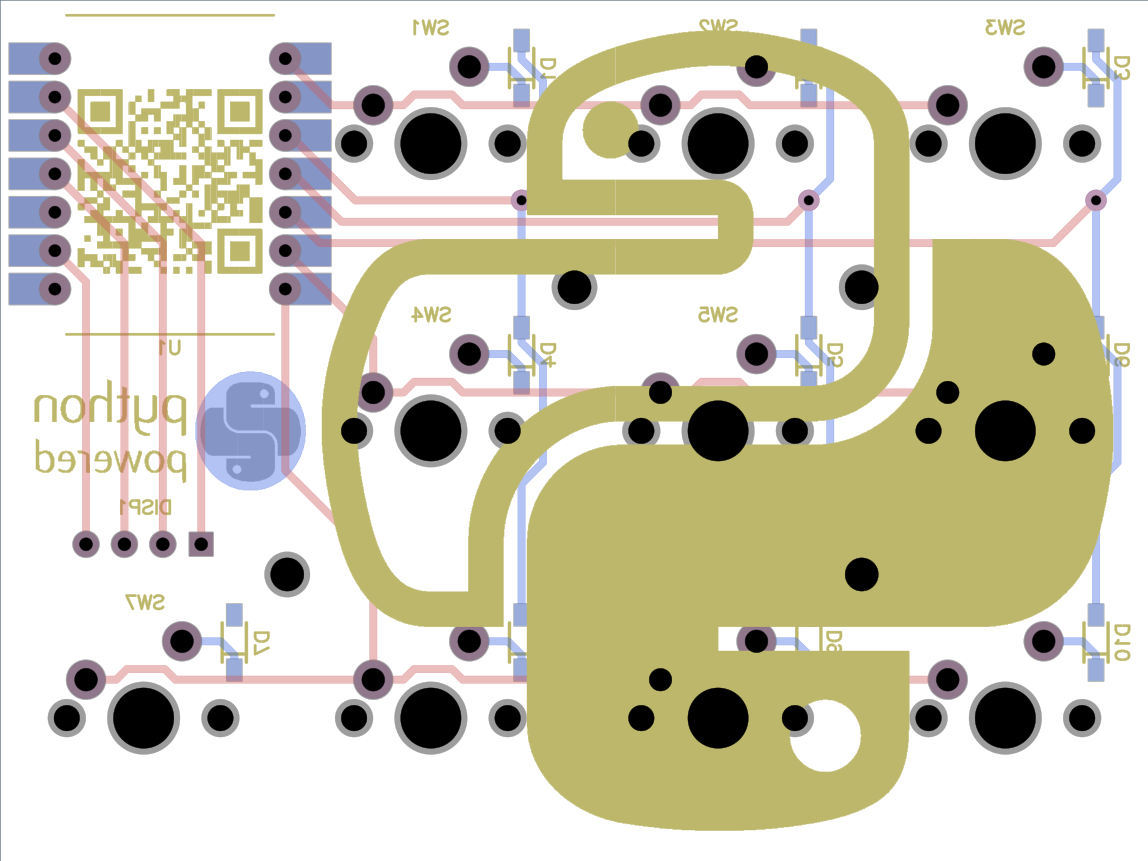

In [30]:
from IPython.display import Image

# 現在のboardをpngファイルとして書き出す
board.save_png("kbd_python", subdir="pcb_png")

# 表示
Image("pcb_png/kbd_python_preview_all.png")
# Image("pcb_png/kbd_python_preview_top.png")
# Image("pcb_png/kbd_python_preview_bot.png")

## 基板上にテキストを配置する
基板のシルクレイヤーにテキストを配置します。

JLCPCBに発注するので注文番号の入る位置を指定しておきます。

In [31]:
board.add_text(
  (47.5, 41.5),
  "https://github.com/hsgw/keyboard_made_by_python",
  scale=1.25,
  side="bottom",
)

board.add_text(
  (BOARD_WIDTH - 39, 5),
  "KEYBOARD MADE BY PYTHON",
  scale=2,
  side="bottom",
  justify="left",
)
board.add_text(
  (BOARD_WIDTH - 44, 4.75),
  "Rev.1",
  scale=1.25,
  side="bottom",
  justify="left",
)
board.add_text(
  (BOARD_WIDTH - 47.5, 2.25),
  "(c) 2022, Takuya Urakawa / Dm9Records / 5z6p.com",
  scale=1.25,
  side="bottom",
  justify="left",
)

# MAGIC WORD for JLCPCB
board.add_text(
  (11.5, 55),
  "JLCJLCJLCJLC",
  scale=1.1,
  side="bottom",
)

### プレビュー

Rendering preview_top.['png']...


/usr/local/lib/python3.8/dist-packages/pcbflow/svgout.py:134: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  [renderpoly(po) for po in gto]
/usr/local/lib/python3.8/dist-packages/pcbflow/svgout.py:142: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for po in gto:
/usr/local/lib/python3.8/dist-packages/pcbflow/svgout.py:115: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  [renderpoly(p) for p in po]


Rendering preview_top_docu.['png']...
Rendering preview_bot.['png']...
Rendering preview_bot_docu.['png']...
Rendering preview_all.['png']...


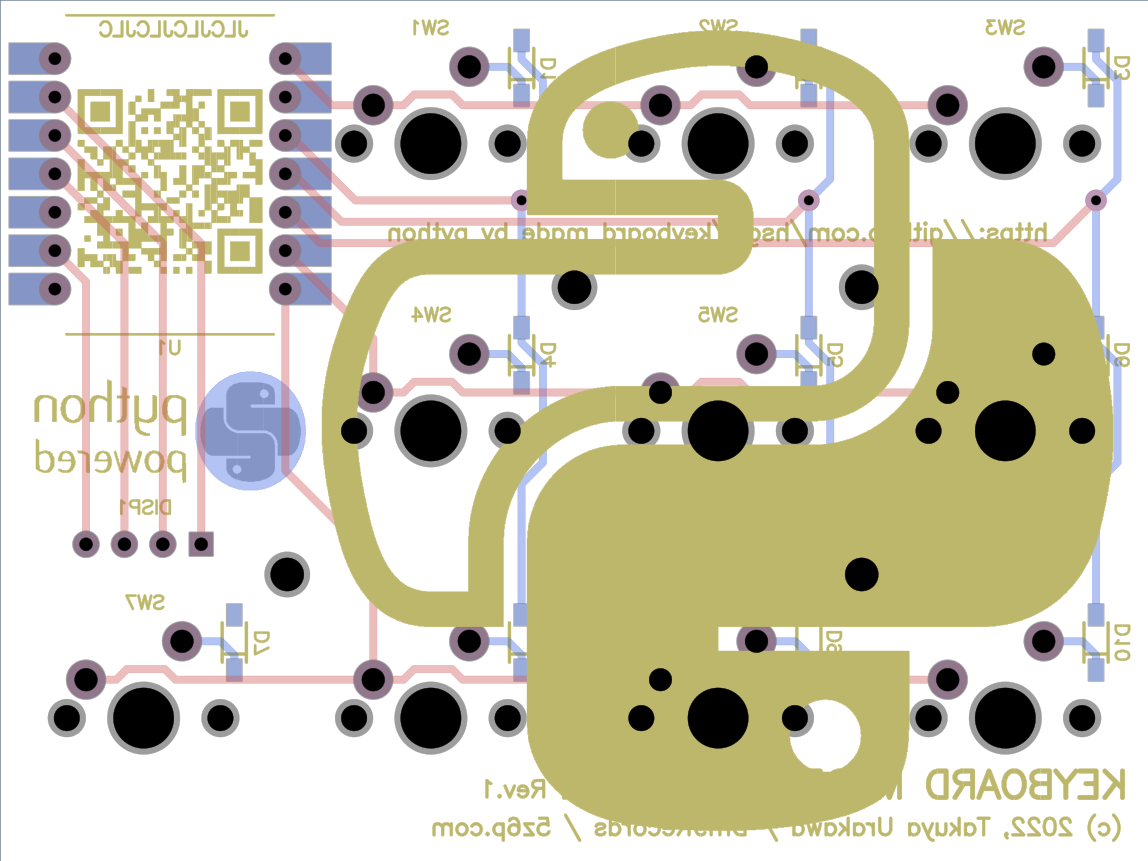

In [32]:
from IPython.display import Image

# 現在のboardをpngファイルとして書き出す
board.save_png("kbd_python", subdir="pcb_png")

# 表示
Image("pcb_png/kbd_python_preview_all.png")
# Image("pcb_png/kbd_python_preview_top.png")
# Image("pcb_png/kbd_python_preview_bot.png")

# 基板の完成とガーバーファイルの出力
最後に製造用ガーバーファイルを出力して完成です。

In [33]:
board.save_gerbers("kbd_python", subdir="pcb_gerber")

Rendering Gerber GTD...
Rendering Gerber GTP...
Rendering Gerber GTO...
Rendering Gerber GTS...
Rendering Gerber GTL...
Rendering Gerber GBL...
Rendering Gerber GBS...
Rendering Gerber GBO...
Rendering Gerber GBP...
Rendering Gerber GBD...
Rendering Gerber GML...
Rendering Gerber DRL...
Rendering excellon drill files...


/usr/local/lib/python3.8/dist-packages/pcbflow/layer.py:210: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  [renderpoly(g, po) for po in surface]
/usr/local/lib/python3.8/dist-packages/pcbflow/layer.py:192: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  [renderpoly(g, p) for p in po]


ガーバーファイルの確認にはkicadのガーバービュアーを使用しました。

![kicadのガーバービュアー](../imgs/kicad_gerberviewer.png)

また、kicadのガーバービュアーからpcbnewのデータへ変換できます。発注時には一度pcbnewへ読み込んでシルクのデータを整えたガーバーファイルを再度出力しました。

![pcbnewへ変換した基板](../imgs/kicad_gerber_to_pcbnew.png)